Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19996 entries, 0 to 19995
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    19996 non-null  object
 1   label   19996 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB
New Label Distribution:
label
 1    10744
-1     9233
Name: count, dtype: int64


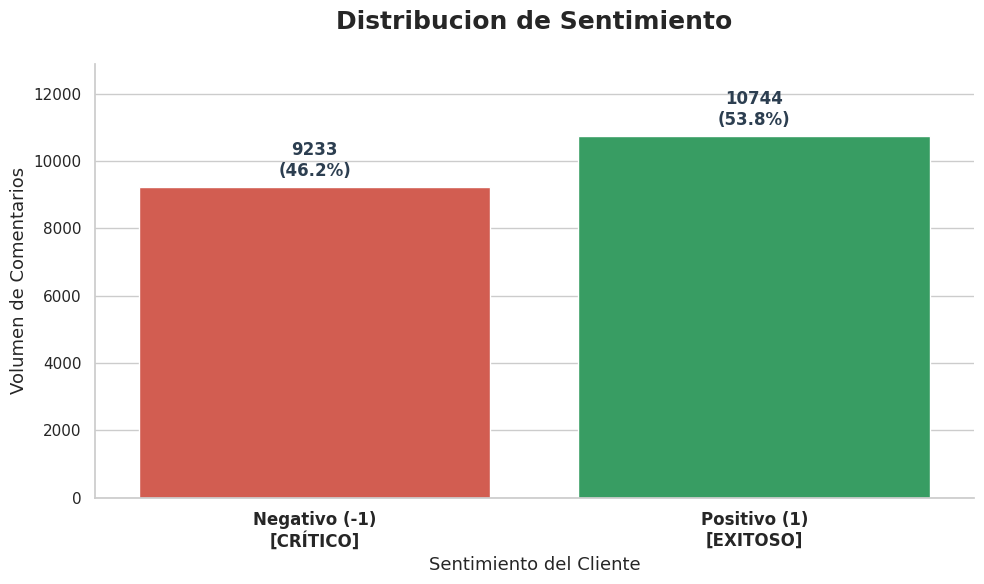

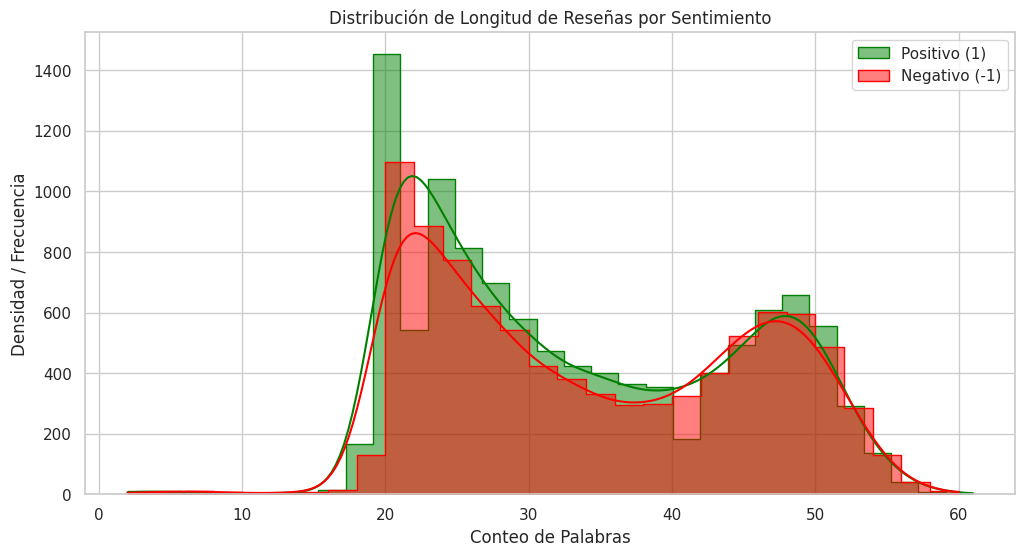


--- Reporte Estadístico por Sentimiento ---
                    mean  median        std  count
label                                             
Negativo (-1)  34.082097    32.0  11.178992   9233
Positivo (1)   33.319155    31.0  11.052146  10744
 Datos listos para el Squad de DS:
   - Entrenamiento: 17492 ejemplos
   - Prueba: 4374 ejemplos
--- MÉTRICAS DE DESEMPEÑO ---
 Accuracy:  0.9561
 Precision: 0.9563
 Recall:    0.9561
 F1-Score:  0.9561

--- REPORTE POR CATEGORÍA ---
               precision    recall  f1-score   support

Negativo (-1)       0.95      0.97      0.96      2267
 Positivo (1)       0.96      0.94      0.95      2107

     accuracy                           0.96      4374
    macro avg       0.96      0.96      0.96      4374
 weighted avg       0.96      0.96      0.96      4374



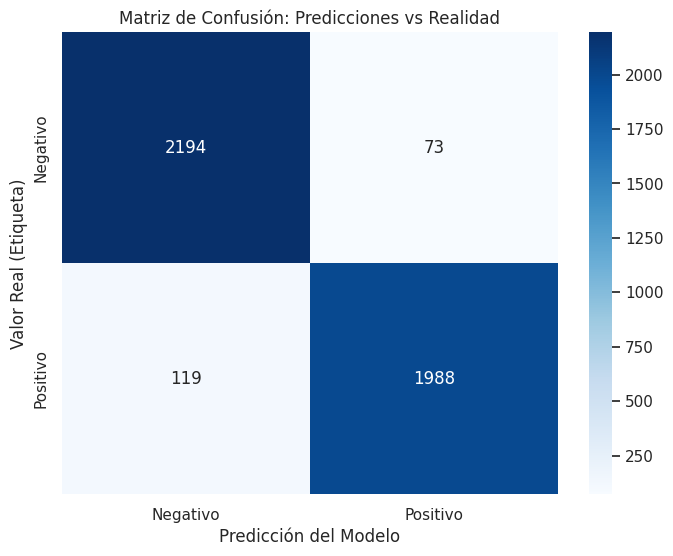

In [1]:
from google.colab import drive
drive.mount('/content/drive') # Montar Google Drive en /content/drive
#https://drive.google.com/file/d/1LKyMPnpqJUR2P7FtodOQgLjFofWzqqno/view?usp=drive_link
# -*- coding: utf-8 -*-
"""Modelo 1.1 kari guti.ipynb

Automatically generated by Colab.

Original file is located at
    https://drive.google.com/file/d/1tdg2AuxrlxZV8TQjGTb7R7VLfFHvgtzL/view?usp=drive_link
"""

# instalamos la libreria de scikit-learn skl2onnx
!pip install scikit-learn skl2onnx onnxruntime onnx

#importamos las librerias a usar en el modelo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType

# cargamos el data set amazon only reviews en ingles
df_amazon = pd.read_csv('/content/drive/MyDrive/amazon_only_reviews_04.csv') # Ruta corregida al archivo CSV

# realizamos la inspeccion de los datos, los primeros 10 en este caso
df_amazon.head(10)

# verificamos la informacion para ver si hay nulos, cantidad de columnas, entre otros
df_amazon.info()

# verificamos la estadistica que en este caso por ser comentarios o reviews pues no dan mayor informacion
df_amazon.describe()

def identify_sentiment(text):
    if not text or str(text).lower() == 'nan':
        return 0

    original_text = str(text)
    text_lower = original_text.lower()

    # Clean the text temporarily to check if it's "garbage"
    cleaned_temp_for_check = re.sub(r'[^a-zñáéíóú\s]', '', text_lower)
    cleaned_temp_for_check = re.sub(r'\s+', ' ', cleaned_temp_for_check).strip()

    # If the cleaned text is empty or very short, consider it neutral (0)
    # This prevents 'garbage' from being classified as negative
    if not cleaned_temp_for_check or len(cleaned_temp_for_check.split()) < 2: # Less than 2 meaningful words
        return 0 # Return 0 for neutral/garbage

    # Define el lexico que me permite identificar las 3 emociones
    pos_words = ['good', 'great', 'love', 'best', 'awesome', 'excellent', 'perfect', 'fun', 'enjoy',
                 'nice', 'amazing', 'fantastic', 'wonderful', 'happy', 'cool', 'super', 'recommend', 'easy'
                 'fast', 'cheap', 'quality', 'delivered', 'arrival', 'shipping', 'helpful', 'thanks']
    neg_words = ['bad', 'worst', 'hate', 'terrible', 'waste', 'boring', 'awful', 'stupid', 'scam',
                 'poor', 'wrong', 'frustrating', 'junk', 'annoying', 'sucks', 'broken', 'return', 'slow',
                 'refund', 'disappointing', 'useless', 'horrible', 'scammer', 'fraud', 'missing', 'bugs',
                 'stole', 'charged', 'late', 'expensive', 'terrible', 'never', 'fail', 'error']

    # Negativos criticos, estas palabras restan doble porque indican fallas graves
    critical_neg = {
            'scam', 'fraud', 'stolen', 'hacked', 'scammer', 'fake', 'missing', 'robado',
            'estafa', 'fraude', 'negligence', 'negligencia', 'unsafe', 'dangerous',
            'dangerous', 'peligroso', 'inseguro', 'stole', 'robó', 'cobrado', 'charged'
        }

    # Tokenización: Separamos por palabras completas para evitar errores
    tokens = re.findall(r'\b\w+\b', cleaned_temp_for_check) # Use the temporarily cleaned text for tokenization

    p_score = sum(1 for w in tokens if w in pos_words)
    n_score = sum(1 for w in tokens if w in neg_words)
    n_score += sum(2.5 for w in tokens if w in critical_neg) # Peso mayor a críticas

    # Si dice "not good", invertimos el sentimiento
    negations = {'not', 'no', 'dont', 'never', 'nuca', 'tampoco'}
    for i in range(len(tokens) - 1):
        if tokens[i] in negations and tokens[i+1] in pos_words:
            n_score += 2
            p_score -= 1

    score = p_score - n_score

    # Si hay palabras críticas (scam, fraud) pero también positivas (good, best) forzamos a que No sea positivo.
    tiene_critica = any(w in tokens for w in critical_neg)

    # ahora se identifica el sentimiento
    if tiene_critica:
        # Si hay una palabra critica, no puede ser positivo, pasamos Negativo.
        return -1
    if score >= 1.0: # Si el puntaje es claramente positivo
        return 1   # Positivo
    else:
        return -1  # Negativo

# Aplicamos la identificacion del sentimiento en la columna label
df_amazon['label'] = df_amazon['Text'].apply(identify_sentiment)

# Filtrar las filas con etiqueta 0 (neutral/basura) para descartarlas
df_amazon = df_amazon[df_amazon['label'] != 0].copy()

# Check distribution
print("New Label Distribution:")
print(df_amazon['label'].value_counts())

# Ahora limpiamos los datos como no hay nulo es mas de forma del texto
def clean_text(text):
  # Convertir a minúsculas
  text = str(text).lower()
  # Eliminar caracteres especiales y números
  text = re.sub(r'[^a-zñáéíóú\s]', '', text)
  # Eliminar espacios múltiples
  text = re.sub(r'\s+', ' ', text).strip()
  return text

df_amazon['Cleaned_Text'] = df_amazon['Text'].apply(clean_text)

# Ahora crearemos la version 1 con el texto corregido
df_amazon_1 = df_amazon[['Cleaned_Text', 'label']].copy()

# guardaremos como un nuevo archivo para respaldo
df_amazon_1.to_csv('amazon_final_cleaned.csv', index=False)

# Realizamos un breve analisis: Contamos palabras y caracteres para entender la estructura de las reseñas
df_amazon_1['word_count'] = df_amazon_1['Cleaned_Text'].apply(lambda x: len(str(x).split()))
df_amazon_1['char_count'] = df_amazon_1['Cleaned_Text'].apply(len)

# Una grafica de la Distribución de Clases
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
palette_colors = {-1: "#E74C3C", 1: "#27AE60"}

ax = sns.countplot(
    x='label',
    data=df_amazon_1,
    palette=palette_colors,
    order=[-1, 1],
    hue='label'
)

# Se elimina la leyenda y se agrega el porcentaje
if ax.get_legend():
    ax.get_legend().remove()

total = len(df_amazon_1)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        percentage = f'{100 * height / total:.1f}%'
        ax.annotate(f'{int(height)}\n({percentage})',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=12, fontweight='bold', color='#2C3E50',
                    xytext=(0, 5), textcoords='offset points')

# titulos y leyenda
plt.title('Distribucion de Sentimiento', fontsize=18, fontweight='bold', pad=25)
plt.xlabel('Sentimiento del Cliente', fontsize=13)
plt.ylabel('Volumen de Comentarios', fontsize=13)
plt.xticks([0, 1], ['Negativo (-1)\n[CRÍTICO]', 'Positivo (1)\n[EXITOSO]'], fontsize=12, fontweight='bold')

plt.ylim(0, df_amazon_1['label'].value_counts().max() * 1.2) # Espacio para las etiquetas
sns.despine() # Elimina bordes innecesarios
plt.tight_layout()

# Guardamos para el reporte
plt.savefig('distribucion_binaria_sentimientos.png', dpi=300)
plt.show()

# Veamos la longitud de las Reseñas
plt.figure(figsize=(12, 6))
# Superponemos los tres histogramas
sns.histplot(df_amazon_1[df_amazon_1['label']==1]['word_count'], color='green', label='Positivo (1)', kde=True, element="step")
sns.histplot(df_amazon_1[df_amazon_1['label']==-1]['word_count'], color='red', label='Negativo (-1)', kde=True, element="step")

plt.title('Distribución de Longitud de Reseñas por Sentimiento')
plt.xlabel('Conteo de Palabras')
plt.ylabel('Densidad / Frecuencia')
plt.legend()
plt.show()

# Grafico de estadisticas descriptivas
print("\n--- Reporte Estadístico por Sentimiento ---")
# Agrupamos por etiqueta, calculamos promedios y medianas
stats = df_amazon_1.groupby('label')['word_count'].agg(['mean', 'median', 'std', 'count'])
# Renombramos el índice para facilitar la comprension
stats.index = stats.index.map({-1: 'Negativo (-1)', 1: 'Positivo (1)'})
print(stats)

# Como se tiene muchos negativos debemos hacer un balance en el dataset
min_samples = df_amazon_1['label'].value_counts().min()
df_balanced_en = df_amazon_1.groupby('label').sample(n=min_samples, random_state=42).reset_index(drop=True)

# Usamos términos clave para que el modelo "entienda" la semántica del español
es_data = {
    'Cleaned_Text': [
        # POSITIVOS (1)
        "excelente servicio", "muy bueno", "me encantó", "perfecto", "increíble",
        "el mejor producto", "muy feliz", "lo recomiendo", "calidad superior", "genial",
        "estupendo", "muy util", "eficaz", "llego super rapido y en optimas condiciones",
        "excelente", "bueno", "mejor", "increíble", "recomendado", "gracias", "rápido",
        "calidad", "feliz", "fácil", "llegó", "bien",
        # NEGATIVOS (-1)
        "pésimo servicio", "estafa total", "no funciona", "muy malo", "una basura",
        "dinero perdido", "parece imitacion", "roto", "horrible", "vendedor estafador", "pésima atención",
        "tarda mucho", "se cuelga", "no responde", "mala calidad", "no corresponde",
        "malo", "peor", "odio", "basura", "estafa", "fraude", "devolución", "inútil",
        "reembolso", "decepcionado", "lento", "caro", "tarde", "fallo", "faltante",
        "nunca", "pésimo", "robado", "cobrado", "aburrido", "falla",
        'pésimo', "horrible", "decepcionante", "error", "molesto"
    ],
    'label': [1]*26 + [-1]*42
}
df_es_1 = pd.DataFrame(es_data)
df_es = pd.concat([df_es_1] * 50, ignore_index=True)

# Creacion de un data set multilingue español e ingles
df_final = pd.concat([df_balanced_en[['Cleaned_Text', 'label']], df_es])

# Definimos nuestras variables X: El texto limpio (la entrada) y: La etiqueta de sentimiento -1, 1 (la salida)
X = df_final['Cleaned_Text']
y = df_final['label']

# Dividimos los datos (80% para entrenar, 20% para evaluar)
# stratify=y asegura que tengamos la misma proporción de -1 y 1 en ambos sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(f" Datos listos para el Squad de DS:")
print(f"   - Entrenamiento: {len(X_train)} ejemplos")
print(f"   - Prueba: {len(X_test)} ejemplos")

# Pipeline de entrenamiento, TfidfVectorizer aprenderá palabras clave en es y en
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        lowercase=True,
        ngram_range=(1, 2)  # <--- CLAVE: Analiza palabras sueltas y pares de palabras ("no bueno")
    )),
    ('clf', LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced' # <--- CLAVE: Compensa si tienes más positivos que negativos
    ))
])

pipeline.fit(X_train, y_train)

# Predicciones con el conjunto de prueba (X_test)
y_pred = pipeline.predict(X_test)

# Calculando métricas en nuestro modelo (-1, 1), usamos average='weighted' para considerar el desbalanceo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("--- MÉTRICAS DE DESEMPEÑO ---")
print(f" Accuracy:  {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1-Score:  {f1:.4f}")

# Ahora el reporte de Clasificación Detallado métricas por cada clase (-1, 1)
print("\n--- REPORTE POR CATEGORÍA ---")
print(classification_report(y_test, y_pred, labels=[-1, 1], target_names=['Negativo (-1)', 'Positivo (1)']))

# La Matriz de Confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión: Predicciones vs Realidad')
plt.xlabel('Predicción del Modelo')
plt.ylabel('Valor Real (Etiqueta)')
plt.show()

def registrar_historial(df_resultado, origen="Individual"):
    """Guarda las predicciones en un archivo acumulativo"""
    archivo_historial = "historial_sentimientos.csv"
    df_resultado['fecha_procesamiento'] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    df_resultado['origen_dato'] = origen

    modo = 'a' if os.path.exists(archivo_historial) else 'w'
    header = not os.path.exists(archivo_historial)
    df_resultado.to_csv(archivo_historial, mode=modo, index=False, header=header)
    print(f"Registro añadido al historial ({archivo_historial})")

def predecir_con_probabilidad_onnx(texto, sess, input_name):
    input_data = np.array([[str(texto)]], dtype=object)
    res = sess.run(None, {input_name: input_data})

    label = res[0][0]  # El -1 o 1
    probs = res[1][0]  # El diccionario o array de probabilidades

    # Extraemos el valor de la probabilidad más alta (Confianza)
    confianza = max(probs.values()) if isinstance(probs, dict) else np.max(probs)

    return label, confianza

def generar_reporte_visual(df):
    """Crea gráficas de torta y barras basadas en los resultados"""

    conteo = df['sentimiento_texto'].value_counts()
    orden = [cat for cat in ['Negativo', 'Positivo'] if cat in conteo.index]
    conteo = conteo.reindex(orden)

    colores_map = {'Positivo': '#27AE60', 'Negativo': '#E74C3C'}
    palette = [colores_map[x] for x in conteo.index]

    plt.figure(figsize=(16, 7))
    sns.set_theme(style="whitegrid")

    # 1. Gráfico de Torta
    plt.subplot(1, 2, 1) # Corrected: Added the third argument for subplot position
    plt.pie(
        conteo,
        labels=conteo.index,
        autopct='%1.1f%%',
        colors=palette,
        startangle=140,
        pctdistance=0.85,
        explode=[0.05] * len(conteo), # Pequeña separación
        textprops={'fontsize': 12, 'fontweight': 'bold'}
    )
    # Círculo central
    centre_circle = plt.Circle((0,0), 0.50, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title('Distribución Porcentual', fontsize=16, fontweight='bold', pad=20)

    # 2. Gráfico de Barras
    plt.subplot(1, 2, 2) # Corrected: Added the third argument for subplot position
    ax = sns.barplot(
        x=conteo.index,
        y=conteo.values,
        hue=conteo.index,
        palette=palette,
        legend=False
    )

    # Añadir etiquetas de cantidad y porcentaje sobre cada barra
    total = sum(conteo.values)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            percentage = f'{100 * height / total:.1f}%'
            ax.annotate(f'{int(height)}\n({percentage})',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom',
                        fontsize=12, fontweight='bold', color='#34495E',
                        xytext=(0, 5), textcoords='offset points')

    plt.title('Volumen Total de Comentarios', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Número de Reseñas', fontsize=12)
    plt.xlabel('Sentimiento Detectado', fontsize=12)

    plt.ylim(0, max(conteo.values) * 1.15)
    sns.despine()

    plt.tight_layout()
    plt.savefig('reporte_grafico_binario.png', dpi=300) # Alta resolución para presentaciones
    plt.show()
    print("✅ Dashboard visual generado: 'reporte_grafico_binario.png'")

def procesar_predicciones(pipeline, datos_entrada, es_archivo=False):
    mapeo_sentimiento = {-1: "Negativo", 1: "Positivo"}

    if not es_archivo:
        # Lógica manual
        texto_limpio = clean_text(datos_entrada)
        pred = pipeline.predict([texto_limpio])[0]
        probs = pipeline.predict_proba([texto_limpio])[0]
        confianza = np.max(probs) # Tomamos la probabilidad más alta
        sentimiento = mapeo_sentimiento[pred]
        df_res = pd.DataFrame([{
            'comentario': datos_entrada,
            'sentimiento_texto': sentimiento,
            'probabilidad': confianza
        }])
        registrar_historial(df_res, "Manual")
        return f"{sentimiento} (Confianza: {confianza:.2%})"
    else:
        # Lógica csv
        df = pd.read_csv(datos_entrada)
        # Lista de posibles nombres de columna (Inglés y Español)
        posibles_columnas = [
            'text', 'reviews', 'review', 'review_body', 'comments', 'comment', 'body', # Inglés
            'comentario', 'comentarios', 'reseña', 'reseñas', 'texto', 'opinion' # Español
        ]
        # Buscamos coincidencias (ignorando mayúsculas/minúsculas)
        col_encontrada = None
        columnas_csv = [c.lower() for c in df.columns]

        for p_col in posibles_columnas:
            if p_col in columnas_csv:
                # Obtenemos el nombre original (con sus mayúsculas originales)
                col_encontrada = df.columns[columnas_csv.index(p_col)]
                break

        if col_encontrada is None:
            # Si no encuentra palabras clave, toma la primera columna por defecto
            col_encontrada = df.columns[0]
            print(f"No se halló columna específica. Usando por defecto: '{col_encontrada}'")
        else:
            print(f"Columna detectada automáticamente: '{col_encontrada}'")

        # Proceso de Predicción
        df['texto_limpio'] = df[col_encontrada].apply(clean_text)
        preds_num = pipeline.predict(df['texto_limpio'])
        probs = pipeline.predict_proba(df['texto_limpio'])
        df['sentimiento_texto'] = [mapeo_sentimiento[p] for p in preds_num]
        df['probabilidad'] = np.max(probs, axis=1)

        # Generar entregables
        df.to_csv("resultado_batch_con_probabilidad.csv", index=False)
        generar_reporte_visual(df)
        df_historial = df[[col_encontrada, 'sentimiento_texto', 'probabilidad']].rename(columns={col_encontrada: 'comentario'})
        registrar_historial(df_historial, "Masivo")

        return f" Éxito. Archivo 'resultado_batch_con_probabilidad.csv' generado con niveles de confianza."

# Conversion a ONNX para el monolito Java
# La entrada: Un string crudo
initial_type = [('text_input', StringTensorType([None, 1]))]

# Convertimos el pipeline completo
onx = convert_sklearn(
    pipeline,
    initial_types=initial_type,
    target_opset=17,
    options={type(pipeline.named_steps['clf']): {'zipmap': False}}
)

# Guardar el archivo binario onnx del modelo
with open("sentiment_binary_multilingual.onnx", "wb") as f:
    f.write(onx.SerializeToString())